<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/final_christine/2d_with_corrections_29_11_optimumtrainingsize_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
pip install albumentations

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [4]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.bn11 = nn.BatchNorm2d(64) # batch normalization
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.bn12 = nn.BatchNorm2d(64) # batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn21 = nn.BatchNorm2d(128) # batch normalization
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.bn22 = nn.BatchNorm2d(128) # batch normalization
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.bn31 = nn.BatchNorm2d(256) # batch normalization
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)
        self.bn32 = nn.BatchNorm2d(256) # batch normalization
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.bn41 = nn.BatchNorm2d(512) # batch normalization
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.bn42 = nn.BatchNorm2d(512) # batch normalization
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.bn51 = nn.BatchNorm2d(1024) # batch normalization
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)
        self.bn52 = nn.BatchNorm2d(1024) # batch normalization

        self.dropout = nn.Dropout(0.5)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.bn11(self.e11(x)))
        xe12 = F.relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        #xp1 = self.dropout(xp1) # dropout
        xe21 = F.relu(self.bn21(self.e21(xp1)))
        xe22 = F.relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xp2 = self.dropout(xp2) # dropout
        xe31 = F.relu(self.bn31(self.e31(xp2)))
        xe32 = F.relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xp3 = self.dropout(xp3) # dropout
        xe41 = F.relu(self.bn41(self.e41(xp3)))
        xe42 = F.relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xp4 = self.dropout(xp4) # dropout
        xe51 = F.relu(self.bn51(self.e51(xp4)))
        xe52 = F.relu(self.bn52(self.e52(xe51)))

        # Up-convolutions
        xup1 = self.upconv1(xe52)
        xup1 = self.dropout(xup1) # dropout
        xcat = torch.cat([xup1, xe42], dim=1)
        #xcat=xup1

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)
        xup2 = self.dropout(xup2) # dropout
        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)
        #xcat2=xup2


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        #xup3 = self.dropout(xup3) # dropout
        xcat3 = torch.cat([xup3, xe22], dim=1)
        #xcat3=xup3

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xup4 = self.dropout(xup4) # dropout
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        #xcat4=xup4

        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        #output = softmax(out, dim=1)
        output=out
        return output

In [5]:
#Setting up hyper parameters, from exercise week 6


loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

import random


In [6]:
test_size=0.35
batch_size = 16

training_idx, test_idx = train_test_split(
    range(300),
    test_size=test_size,
    random_state=42
)


val_idx, test_idx = train_test_split(
    test_idx,
    test_size=0.5,
    random_state=42
)


In [7]:
training_file_names=[]
label_train_names=[]
for i in range(len(training_idx)):
  if len(str(training_idx[i]))<2:
    training_file_names.append('SOCprist000'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__00'+str(training_idx[i])+'.tif')
  if len(str(training_idx[i]))==2:
    training_file_names.append('SOCprist00'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__0'+str(training_idx[i])+'.tif')
  else:
    training_file_names.append('SOCprist0'+str(training_idx[i])+'.tiff')
    label_train_names.append('slice__'+str(training_idx[i])+'.tif')

In [8]:
test_file_names=[]
label_test_names=[]
for i in range(len(test_idx)):
  if len(str(test_idx[i]))<2:
    test_file_names.append('SOCprist000'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__00'+str(test_idx[i])+'.tif')
  if len(str(test_idx[i]))==2:
    test_file_names.append('SOCprist00'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__0'+str(test_idx[i])+'.tif')
  else:
    test_file_names.append('SOCprist0'+str(test_idx[i])+'.tiff')
    label_test_names.append('slice__'+str(test_idx[i])+'.tif')

In [9]:
val_file_names=[]
label_val_names=[]
for i in range(len(val_idx)):
  if len(str(val_idx[i]))<2:
    val_file_names.append('SOCprist000'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__00'+str(val_idx[i])+'.tif')
  if len(str(val_idx[i]))==2:
    val_file_names.append('SOCprist00'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__0'+str(val_idx[i])+'.tif')
  else:
    val_file_names.append('SOCprist0'+str(val_idx[i])+'.tiff')
    label_val_names.append('slice__'+str(val_idx[i])+'.tif')

In [10]:
class Trainingdataset(Dataset):
    def __init__(self, root_dir, transform=None,file_names=None,label_names=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform
        self.file_names= file_names
        self.label_names= label_names

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f in self.file_names])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f in self.file_names])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5] #make sure the label fits with the image
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [11]:

transform = A.Compose(
    [
     #A.HorizontalFlip(p=0.3),
     A.RandomCrop(width=128, height=128),
     #A.VerticalFlip(p=0.1),
     #A.RandomBrightnessContrast(p=0.05),  # Adjust brightness/contrast
     A.GaussNoise(p=0.05),  # Add Gaussian noise
     #A.Resize(64, 64, p=0.2),  # Downsample to 64x64
     #A.Resize(128, 128),  # Upsample back to 128x128
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)

#The transformations fro test only consist of normalization and to tensor transform
transform_val = A.Compose(
    [
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)



In [12]:
SOC_dataset_train = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=training_file_names,label_names=label_train_names)
SOC_dataset_test = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=test_file_names,label_names=label_test_names)
SOC_dataset_val = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform_val,file_names=val_file_names,label_names=label_val_names)

In [13]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.7 MB/s eta 0:00:00


In [14]:
from torchmetrics.classification import JaccardIndex
from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy

In [15]:
test_size=0.3
batch_size = 16

#train_loader = DataLoader(Subset(SOC_dataset, training_idx), batch_size=batch_size, shuffle=True,drop_last=False)
#test_loader = DataLoader(Subset(SOC_dataset, test_idx), batch_size=batch_size,drop_last=True)
#val_loader = DataLoader(SOC_dataset_label, batch_size=batch_size,drop_last=True)

train_loader = DataLoader(SOC_dataset_train, batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(SOC_dataset_test, batch_size=batch_size,drop_last=True)
val_loader = DataLoader(SOC_dataset_val, batch_size=batch_size,drop_last=True)


In [16]:
'''
This function evaluates the model on a validation set.
It calculates the
    - Dice coefficient,
    - Jaccard index,
    - pixel-wise accuracy for the model's predictions
'''
def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    total_dice = 0
    total_jaccard = 0
    total_pixel_accuracy = 0
    num_batches = 0

    with torch.no_grad():  # No need to track gradients
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert targets according to unique values
            un_target = targets.unique()
            targets[targets == un_target[0]] = 0
            targets[targets == un_target[1]] = 1
            targets[targets == un_target[2]] = 2
            targets = targets.to(torch.int64)

            # Get predictions
            predictions = outputs.max(1)[1]

            # Update metrics
            total_dice += dice(predictions, targets).item()
            total_jaccard += jaccard(predictions, targets).item()
            total_pixel_accuracy += accuracy(predictions, targets).item()
            num_batches += 1

    # Calculate average metrics
    avg_dice = total_dice / num_batches
    avg_jaccard = total_jaccard / num_batches
    avg_pixel_accuracy = total_pixel_accuracy / num_batches

    return avg_dice, avg_jaccard, avg_pixel_accuracy

In [19]:
# #Code is inspired by exercise 4.2-EXE-CNN-CIFAR-10.ipynb
net=UNet(n_class=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.0001) #choosing the Adam optimizzer

#Defining the different accuracy metrics
jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16 #batchsize
num_epochs = 50
validation_every_steps = np.ceil(len(train_loader.dataset)/batch_size) #How often the validation should be

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []
loss_epochs=[]
test_losses=[]
loss_train=[]
test_loss=[]


# Define the range for the number of images
num_images_options = [100, 200, 300, 400, 500]

# Initialize a structure to store results
results = []

for num_images in num_images_options:
    print(f"Training with {num_images} images")

    test_size=0.35
    batch_size = 16

    training_idx, test_idx = train_test_split(
        range(num_images),
        test_size=test_size,
        random_state=42
    )


    val_idx, test_idx = train_test_split(
        test_idx,
        test_size=0.5,
        random_state=42
    )

    training_file_names=[]
    label_train_names=[]
    for i in range(len(training_idx)):
      if len(str(training_idx[i]))<2:
        training_file_names.append('SOCprist000'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__00'+str(training_idx[i])+'.tif')
      if len(str(training_idx[i]))==2:
        training_file_names.append('SOCprist00'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__0'+str(training_idx[i])+'.tif')
      else:
        training_file_names.append('SOCprist0'+str(training_idx[i])+'.tiff')
        label_train_names.append('slice__'+str(training_idx[i])+'.tif')

    test_file_names=[]
    label_test_names=[]
    for i in range(len(test_idx)):
      if len(str(test_idx[i]))<2:
        test_file_names.append('SOCprist000'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__00'+str(test_idx[i])+'.tif')
      if len(str(test_idx[i]))==2:
        test_file_names.append('SOCprist00'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__0'+str(test_idx[i])+'.tif')
      else:
        test_file_names.append('SOCprist0'+str(test_idx[i])+'.tiff')
        label_test_names.append('slice__'+str(test_idx[i])+'.tif')

    val_file_names=[]
    label_val_names=[]
    for i in range(len(val_idx)):
      if len(str(val_idx[i]))<2:
        val_file_names.append('SOCprist000'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__00'+str(val_idx[i])+'.tif')
      if len(str(val_idx[i]))==2:
        val_file_names.append('SOCprist00'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__0'+str(val_idx[i])+'.tif')
      else:
        val_file_names.append('SOCprist0'+str(val_idx[i])+'.tiff')
        label_val_names.append('slice__'+str(val_idx[i])+'.tif')

    SOC_dataset_train = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=training_file_names,label_names=label_train_names)
    SOC_dataset_test = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform,file_names=test_file_names,label_names=label_test_names)
    SOC_dataset_val = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform_val,file_names=val_file_names,label_names=label_val_names)

    # Initialize Data Loaders

    train_loader = DataLoader(SOC_dataset_train, batch_size=batch_size, shuffle=True,drop_last=False)
    test_loader = DataLoader(SOC_dataset_test, batch_size=batch_size,drop_last=True)
    val_loader = DataLoader(SOC_dataset_val, batch_size=batch_size,drop_last=True)

    # Reinitialize the model and optimizer
    net = UNet(n_class=3)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    for epoch in range(num_epochs):
        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []
        loss_epochs=[]

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass.
            output = net(inputs)

            #Divide targets into classes: [0,1,2]
            un_target=targets.unique()
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            #compute loss function
            loss = loss_fn(output, targets)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1) #Prediction with max of softmax output
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())
            loss_epochs.append(loss.detach().cpu().numpy())
            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))
                loss_train.append(np.mean(loss_epochs))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                test_losses=[]
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in test_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())
                        test_losses.append(loss.cpu())
                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
                valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
                valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))
                test_loss.append(np.mean(test_losses))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")
                print(f"             loss in test: {test_loss[-1]}")

    # Evaluate the model
    #avg_dice, avg_jaccard, avg_pixel_accuracy = evaluate_model(net, val_loader, device)
    avg_dice=valid_accuracies_dice[-1]
    avg_jaccard=valid_accuracies_jaccard[-1]
    avg_pixel=valid_accuracies_pixel[-1]

    # Store results
    results.append((num_images, avg_dice, avg_jaccard, avg_pixel))

print("Finished training.")

Training with 100 images
Step 5       training accuracy with jaccard: 0.40665650367736816
             training accuracy with dice: 0.5623481869697571
             training accuracy with pixel by pixel: 0.6163296103477478
             test accuracy with jaccard: 0.08185577392578125
             test accuracy with dice: 0.24556732177734375
             test accuracy with pixel by pixel: 0.3333333432674408
             loss in test: 1.1031655073165894
Step 10      training accuracy with jaccard: 0.8965772390365601
             training accuracy with dice: 0.9461158514022827
             training accuracy with pixel by pixel: 0.9457615613937378
             test accuracy with jaccard: 0.4756392538547516
             test accuracy with dice: 0.67401123046875
             test accuracy with pixel by pixel: 0.6330093145370483
             loss in test: 1.0691667795181274
Step 15      training accuracy with jaccard: 0.8895395994186401
             training accuracy with dice: 0.94020080566406

In [23]:
def plot_results(results):
    # Create a DataFrame from the results
    df = pd.DataFrame(results, columns=["Num Images", "Dice", "Jaccard", "Pixel Accuracy"])

    # Reshape the DataFrame for easier plotting
    df_melted = df.melt(id_vars=["Num Images"], value_vars=["Dice", "Jaccard", "Pixel Accuracy"],
                        var_name="Metric", value_name="Accuracy")

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_melted, x="Num Images", y="Accuracy", hue="Metric", marker="o")
    plt.title("Accuracy Metrics vs. Number of Images")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Images")
    plt.legend(title="Metric")
    plt.grid(True)
    plt.show()




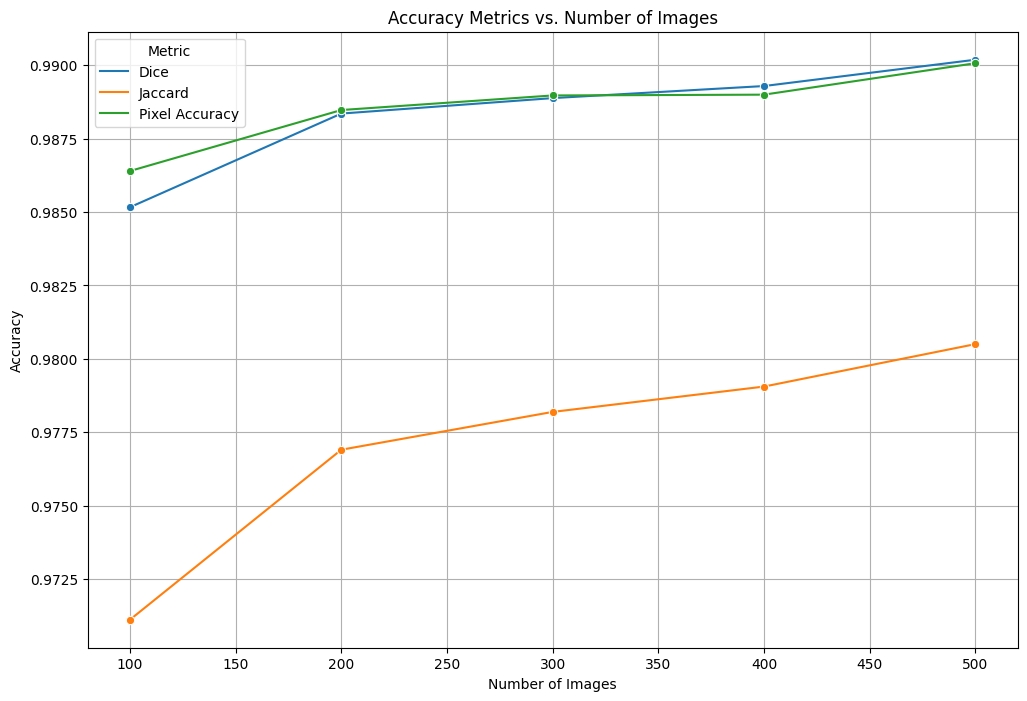

In [25]:

# Call the plotting function
plot_results(results)

# Optimization

In [ ]:
val_acc_dice=[]
val_acc_jaccard=[]
val_acc_pixel=[]

for inputs, targets in val_loader:
  inputs_val, targets = inputs.to(device), targets.to(device)

un_target=targets.unique()
# Compute loss.
targets[targets==un_target[0]]=0
targets[targets==un_target[1]]=1
targets[targets==un_target[2]]=2

targets_val=targets

In [ ]:
kernel_size = 128
stride = 128

pad_min=int(np.floor((kernel_size*np.ceil(inputs_val.size(-1)/kernel_size)-inputs_val.size(-1))/2))
pad_max=int(np.ceil((kernel_size*np.ceil(inputs_val.size(-1)/kernel_size)-inputs_val.size(-1))/2))

inputs_val=torch.nn.functional.pad(inputs_val,pad=(pad_min,pad_max,pad_min,pad_max)) #to get the size to 512 (4*128)
targets_val=torch.nn.functional.pad(targets_val,pad=(pad_min,pad_max,pad_min,pad_max)) #to get the size to 512 (4*128)

#Inspired by https://discuss.pytorch.org/t/how-to-split-tensors-with-overlap-and-then-reconstruct-the-original-tensor/70261/7?fbclid=IwAR1rdUAuDnUpVm2OwmXRaFo-l2AMLJ1RLn5bJEp6f1JcU7wR5CHpugMHc6Y
B, C, W, H = inputs_val.size(0), inputs_val.size(1), inputs_val.size(2), inputs_val.size(3)

images_split_1 = inputs_val.unfold(3, kernel_size, stride).unfold(2, kernel_size, stride).permute(0,1,2,3,5,4)
targets_split=targets_val.unfold(2, kernel_size, stride).unfold(1, kernel_size, stride).permute(0,1,2,4,3)


In [ ]:
#Trying to create overlap matrix....not working yet
overlap=torch.ones([inputs_val.size(-1),inputs_val.size(-1)])
for i in range(overlap.size(0)):
  for j in range(overlap.size(1)):
    if (i>stride) & (j>stride) & (i<inputs_val.size(-1)-stride) & (j<inputs_val.size(-1)-stride):
      overlap[i,j]=4


In [ ]:
plt.imshow(overlap)
plt.colorbar()

In [ ]:
preds=torch.empty(images_split_1.size(0),images_split_1.size(2),images_split_1.size(3),images_split_1.size(-1), images_split_1.size(-1))
tar=targets_split

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for i in range(images_split_1.size(2)):
  for j in range(images_split_1.size(3)):
    output_val = net(images_split_1[:,:,i,j,:,:])
    predicted_val = output_val.max(1)[1]

    val_acc_dice.append(dice(predicted_val,tar[:,i,j,:,:]))
    val_acc_jaccard.append(jaccard(predicted_val,tar[:,i,j,:,:]))
    val_acc_pixel.append(accuracy(predicted_val,tar[:,i,j,:,:]))


    output=output_val
    targets=tar[0,i,j,:,:]
    predicted=predicted_val
    inputs=images_split_1[:,:,i,j,:,:]

    fig,axs = plt.subplots(2,2,figsize=(15,10),dpi=200)
    im1=axs[0,0].imshow(output.detach().cpu().numpy()[0,0,:,:])
    axs[0,0].set_title('Label 1, probability')
    axs[0,0].set_xlabel('Number of pixels [#]')
    axs[0,0].set_ylabel('Number of pixels [#]')
    cbar1=plt.colorbar(im1, ax=axs[0,0],label='Probability', pad=0.1)
    im1.set_clim(0,1)
    im2=axs[1,0].imshow(output.detach().cpu().numpy()[0,1,:,:])
    axs[1,0].set_title('Label 2, probability')
    plt.colorbar(im2, ax=axs[1,0],label='Probability', pad=0.1)
    im2.set_clim(0,1)
    im3=axs[0,1].imshow(output.detach().cpu().numpy()[0,2,:,:])
    axs[1,0].set_xlabel('Number of pixels [#]')
    axs[1,0].set_ylabel('Number of pixels [#]')
    axs[0,1].set_title('Label 3,probabiliy')
    plt.colorbar(im3, ax=axs[0,1],label='Probability', pad=0.1)
    im3.set_clim(0,1)
    axs[0,1].set_xlabel('Number of pixels [#]')
    axs[0,1].set_ylabel('Number of pixels [#]')
    im4=axs[1,1].imshow(targets.cpu())
    axs[1,1].set_title('Target labels')
    axs[1,1].set_xlabel('Number of pixels [#]')
    axs[1,1].set_ylabel('Number of pixels [#]')
    plt.colorbar(im4, ax=axs[1,1],ticks=[0,1,2],label='Label number', pad=0.1)
    #fig.suptitle('Probability distribution for each class', fontsize=16)
    plt.tight_layout()
    plt.show()

    fig,axs=plt.subplots(2,2,figsize=(15,10),dpi=200)
    im1=axs[1,0].imshow(predicted[0,:,:].cpu())
    axs[1,0].set_title('Predicted labels')
    axs[1,0].set_xlabel('Number of pixels [#]')
    axs[1,0].set_ylabel('Number of pixels [#]')
    plt.colorbar(im1, ax=axs[1, 0],ticks=[0,1,2],label='Label number', pad=0.1)
    im2=axs[1,1].imshow(targets.cpu())
    axs[1,1].set_title('Target labels')
    plt.colorbar(im2, ax=axs[1,1],ticks=[0,1,2],label='Label number', pad=0.1)
    axs[1,1].set_xlabel('Number of pixels [#]')
    axs[1,1].set_ylabel('Number of pixels [#]')
    im3=axs[0,0].imshow(inputs[0,0,:,:].cpu())
    axs[0,0].set_title('Original image')
    plt.colorbar(im3, ax=axs[0,0],label='Normalized intensities', pad=0.1)
    axs[0,0].set_xlabel('Number of pixels [#]')
    axs[0,0].set_ylabel('Number of pixels [#]')
    im4=axs[0,1].imshow(np.abs(targets.detach().cpu().numpy()-predicted[0,:,:].detach().cpu().numpy()))
    axs[0,1].set_title('Difference in labels')
    axs[0,1].set_xlabel('Number of pixels [#]')
    axs[0,1].set_ylabel('Number of pixels [#]')
    plt.colorbar(im4, ax=axs[0,1],ticks=[0,1,2],label='Absolute difference in labels', pad=0.1)

    #fig.suptitle('Comparison of target and predicted mask', fontsize=16)
    plt.tight_layout()
    plt.show()


    preds[:,i,j,:,:]=predicted_val

In [ ]:
#Inspired by https://discuss.pytorch.org/t/how-to-split-tensors-with-overlap-and-then-reconstruct-the-original-tensor/70261/7?fbclid=IwAR1rdUAuDnUpVm2OwmXRaFo-l2AMLJ1RLn5bJEp6f1JcU7wR5CHpugMHc6Y
patches = preds.contiguous().view(B, -1, kernel_size*kernel_size)
patches = patches.permute(0,2,1)
patches = patches.contiguous().view(B, C*kernel_size*kernel_size, -1)

output = torch.nn.functional.fold(
    patches, output_size=(H, W), kernel_size=kernel_size, stride=stride)
print(output.shape) # [B, C, H, W]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(dpi=200)
plt.imshow(output[0,0,:,:].detach().cpu())
plt.colorbar(ticks=[0,1,2],label='Label number')
plt.title('Predicted labels')
plt.xlabel('Number of pixels [#]')
plt.ylabel('Number of pixels [#]')

plt.figure(dpi=200)
plt.imshow(targets_val[0,:,:].detach().cpu())
plt.colorbar(ticks=[0,1,2],label='Label number')
plt.title('Target labels')
plt.xlabel('Number of pixels [#]')
plt.ylabel('Number of pixels [#]')

plt.figure(dpi=200)
plt.imshow(np.abs(targets_val[0,:,:].detach().cpu().numpy()-output[0,0,:,:].detach().cpu().numpy()))
plt.colorbar(ticks=[0,1,2],label='Absolute label difference')
plt.title('Prediction vs. targets')
plt.xlabel('Number of pixels [#]')
plt.ylabel('Number of pixels [#]')


In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig,axs=plt.subplots(1,2,figsize=(15,5))

axs[0].plot(train_accuracies_dice,color='red',label='Dice')
axs[0].plot(train_accuracies_jaccard,color='blue',label='Jaccard')
axs[0].plot(train_accuracies_pixel,color='green',label='Pixel-wise')
axs[0].grid()
axs[0].legend()
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])

axs[1].plot(valid_accuracies_dice,color='red',label='Dice')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Jaccard')
axs[1].plot(valid_accuracies_pixel,color='green',label='Pixel-wise')
axs[1].legend()
axs[1].grid()
axs[1].set_title('Validation accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,1])
plt.tight_layout()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='Training accuracy')
axs[0].plot(valid_accuracies_dice,color='blue',label='Validation accuracy')
axs[0].set_title('Dice coefficient accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0,1])

axs[1].plot(train_accuracies_jaccard,color='red',label='Training accuracy')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Validation accuracy')
axs[1].set_title('Jaccard coefficient accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].grid()
axs[1].legend()
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,1])

axs[2].plot(train_accuracies_pixel,color='red',label='Training accuracy')
axs[2].plot(valid_accuracies_pixel,color='blue',label='Validation accuracy')
axs[2].set_title('Pixel-wise coefficient accuracies')
axs[2].set_xlabel('Epoch number')
axs[2].grid()
axs[2].legend()
axs[2].set_ylabel('Accuracy')
axs[2].set_ylim([0,1])

plt.tight_layout()

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig,axs=plt.subplots(1,1,figsize=(15,5))
axs.plot(loss_train,color='blue',label='Training loss')
axs.plot(test_loss,color='red',label='Test loss')
axs.legend()
axs.grid()
axs.set_title('Loss')
axs.set_xlabel('Epoch number')
axs.set_ylabel('Loss')
axs.set_ylim([0,1])

plt.tight_layout()

 -

 -

# Determining the optimum training size

In [ ]:
class SOCDataset(Dataset):
    def __init__(self, root_dir, transform=None,transform_flip=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform
        self.transform_flip = transform_flip

        # self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][:300])
        # self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')][:300])
        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')])

    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5]
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [ ]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive//AI data/', transform = transform)

In [ ]:

# Define a range of training sizes to experiment with
# Works by generating an array of numbers evenly spaced between two specified values
training_sizes = np.linspace(0.1, 0.9, 10)  # For example, 10% to 100% of the training data
# print(training_sizes)

BATCH_SIZE = 16
SEED = 42

# Initialize lists to store metrics for each training size
training_size_results = {
    "size": [],
    "validation_accuracy_dice": [],
    "validation_accuracy_jaccard": [],
    "validation_accuracy_pixel": []
}

num_images = len(SOC_dataset)
print(f"Number of images in the dataset: {num_images}")


for train_size in training_sizes:
    # Split the dataset according to the current training size
    train_size_actual = int(train_size * len(SOC_dataset))
    train_indices, remaining_indices = train_test_split(
        range(len(SOC_dataset)),
        train_size=train_size_actual,
        random_state=SEED
    )

    # Further split the remaining data into validation and test sets
    val_indices, test_indices = train_test_split(
        remaining_indices,
        test_size=0.5,
        random_state=SEED
    )

    # Create data subsets for each split
    train_split = Subset(SOC_dataset, train_indices)
    val_split = Subset(SOC_dataset, val_indices)
    test_split = Subset(SOC_dataset, test_indices)

    # DataLoader setup
    train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

    # Reinitialize the model and optimizer
    net = UNet(n_class=3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Train the model (using the above training loop)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
    accuracy=MulticlassAccuracy(num_classes=3).to(device)
    batch_size = 16
    num_epochs = 25 #changing the num_epochs from 2 to 12
    validation_every_steps = 10

    step = 0
    net.train()

    train_accuracies_jaccard = []
    train_accuracies_dice = []
    train_accuracies_pixel = []
    valid_accuracies_jaccard = []
    valid_accuracies_dice = []
    valid_accuracies_pixel = []

    count : int = 1

    for epoch in range(num_epochs):

        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass, compute gradients, perform one training step.
            # Your code here!
            # Forward pass.
            output = net(inputs)

            un_target=targets.unique()
            # Compute loss.
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            loss = loss_fn(output, targets)

            # Clean up gradients from the model.
            optimizer.zero_grad()

            # Compute gradients based on the loss from the current batch (backpropagation).
            loss.backward()

            # Take one optimizer step using the gradients computed in the previous step.
            optimizer.step()

            # Increment step counter
            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1)
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in test_loader: # Change to val_loader from test_loader
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.mean(valid_accuracies_batches_jaccard))
                valid_accuracies_dice.append(np.mean(valid_accuracies_batches_dice))
                valid_accuracies_pixel.append(np.mean(valid_accuracies_batches_pixel))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")

    # Evaluate on the validation set
    val_dice, val_jaccard, val_pixel = evaluate_model(net, val_loader, device)

    # Store the results
    training_size_results["size"].append(train_size)
    training_size_results["validation_accuracy_dice"].append(val_dice)
    training_size_results["validation_accuracy_jaccard"].append(val_jaccard)
    training_size_results["validation_accuracy_pixel"].append(val_pixel)

    print(f"Finished training {count}.")
    count += 1



In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_dice"], label='Dice')
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_jaccard"], label='Jaccard')
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_pixel"], label='Pixel-wise')
plt.xlabel('Training Size (Fraction)')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance vs Training Size (500 Images)')
plt.legend()
plt.show()

In [ ]:
print('Accuracies:')

for i, size in enumerate(training_size_results["size"]):
  print()
  print(f"\nTraining Size: {size}")
  print(f"Dice Accuracy: {training_size_results['validation_accuracy_dice'][i]}")
  print(f"Jaccard Accuracy: {training_size_results['validation_accuracy_jaccard'][i]}")
  print(f"Pixel Accuracy: {training_size_results['validation_accuracy_pixel'][i]}")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch

# Assuming SOC_dataset, UNet, dice, jaccard, accuracy, and loss_fn are defined

# Define the total number of images and the subset sizes you want to test
total_images = 500
subset_sizes = [50, 100, 200, 300, 400, 500]  # Example subset sizes

# Initialize a dictionary to store the results
results = {
    "subset_size": [],
    "validation_accuracy_dice": [],
    "validation_accuracy_jaccard": [],
    "validation_accuracy_pixel": []
}

for size in subset_sizes:
    # Select a random subset of the dataset
    subset_indices = np.random.choice(range(len(SOC_dataset)), size, replace=False)
    dataset_subset = Subset(SOC_dataset, subset_indices)

    # Split the subset into training and validation
    train_indices, val_indices = train_test_split(range(len(dataset_subset)), test_size=0.2)
    train_subset = Subset(dataset_subset, train_indices)
    val_subset = Subset(dataset_subset, val_indices)

    # DataLoader setup
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)

    # Initialize the model, loss function, and optimizer
    net = UNet(n_class=3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Train the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
    accuracy=MulticlassAccuracy(num_classes=3).to(device)
    batch_size = 16
    num_epochs = 25
    validation_every_steps = 10

    step = 0
    net.train()

    train_accuracies_jaccard = []
    train_accuracies_dice = []
    train_accuracies_pixel = []
    valid_accuracies_jaccard = []
    valid_accuracies_dice = []
    valid_accuracies_pixel = []

    for epoch in range(num_epochs):

        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass, compute gradients, perform one training step.
            # Your code here!
            # Forward pass.
            output = net(inputs)

            un_target=targets.unique()
            # Compute loss.
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            loss = loss_fn(output, targets)

            # Clean up gradients from the model.
            optimizer.zero_grad()

            # Compute gradients based on the loss from the current batch (backpropagation).
            loss.backward()

            # Take one optimizer step using the gradients computed in the previous step.
            optimizer.step()

            # Increment step counter
            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1)
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.mean(valid_accuracies_batches_jaccard))
                valid_accuracies_dice.append(np.mean(valid_accuracies_batches_dice))
                valid_accuracies_pixel.append(np.mean(valid_accuracies_batches_pixel))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")



    # Evaluate on the validation set
    val_dice, val_jaccard, val_pixel = evaluate_model(net, val_loader, device)

    # Store the results
    results["subset_size"].append(size)
    results["validation_accuracy_dice"].append(val_dice)
    results["validation_accuracy_jaccard"].append(val_jaccard)
    results["validation_accuracy_pixel"].append(val_pixel)

    print("Finished training.")



In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results["subset_size"], results["validation_accuracy_dice"], label='Dice')
plt.plot(results["subset_size"], results["validation_accuracy_jaccard"], label='Jaccard')
plt.plot(results["subset_size"], results["validation_accuracy_pixel"], label='Pixel-wise')
plt.xlabel('Number of Images in Training Subset')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance vs Number of Training Images')
plt.legend()
plt.show()

In [ ]:
print('Image Count Accuracies:')

for i, size in enumerate(results["subset_size"]):
  print()
  print(f"\nTraining Size: {size}")
  print(f"Dice Accuracy: {results['validation_accuracy_dice'][i]}")
  print(f"Jaccard Accuracy: {results['validation_accuracy_jaccard'][i]}")
  print(f"Pixel Accuracy: {results['validation_accuracy_pixel'][i]}")